# Project 1 - biophysics TMA4320

Monomers are membraneless organells and are the building blocks of polymers. In this project we are studying the formation of polymers. The monomers have a charge, either the positive or the negative elementary charge. Thus there are electric forces between the monomers, but there are other factors such as pH-value and the use of catalysators that also have influence on the interaction between monomers. To simplify we are only going to look at the electric forces in this problem. Then we can use coulombs law $F = \frac{q_1 q_2}{4 \pi \epsilon_0 \epsilon_r r^2}$ to calculate the interaction between the monomers. Furthermore we simplify the interaction by only considering the forces between the monomer and it's nearest neighbours. The nearest neighbours is defined by the monomer to the left, right, over and under to the monomer. For monomers in the same polymer we have set the force to be equal to zero, so we don't take the forces inside the polymer to consideration. Moreover, to be able to make a simulation we use time discretisation and discretisation of position. As a result of the discretisation and the simplifications we can calculate the total energy of a state by $$ E = \sum_{k,l} V_{kl}$$, where $V_{kl} = \omega_k \omega_l \alpha$ if $r_l$ and $r_k$ are neighbours $0$ otherwise. 

To simulate the behaviour we are using the Metropolis algorithm, which is a Markov chain Monte Carlo method. To calculate the next state, the algorithm only takes the information from the current state and some randomness. The system seek to be in equilibrium and this is generally achieved by only doing moves that minimizes the energy. Thus if the energy of the new state is lower than in the current state, the new state is the new current state. Otherwise we look at the probability of the system being in a given state. The probability of a system being in a given state $S$ is given by $f(S) = \frac{1}{Z} \exp(-\beta E(S))$. Where Z is the partition function and $\beta = \frac{1}{k_b T}$. The ratio $\frac{S_n}{S_i} = \exp(-\beta (E(S_n)- E(S_i)))$ is a quantity that says something about how likely the new state is in comparison to the old. The randomness in the simulation is tied to this ratio, and it is aphenomenon called thermal fluctution. If the ratio is larger than a random number between 0 and 1, $p$, the new state is the new current state. Since the ratio is dependent on temperature, the simulation will yield different results with different temperatures.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import random
import time
from scipy.constants import Boltzmann, epsilon_0, elementary_charge

%pip install numba
#Using numba to speed up the functions
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Note: you may need to restart the kernel to use updated packages.


## Monomers

In [2]:
#parameters
e_r = 78
a = (23*1.e-6)**2

#exercise 1a
@jit(nopython=True)
def generate_grid_monomers(N, M):
    grid = np.zeros((N,N), dtype=np.dtype('i2'))

    for i in range(1,M+1):
        #positive charged monomers
        x_p = randint(0,N-1)
        y_p = randint(0,N-1)

        while grid[y_p][x_p] != 0:
            x_p = randint(0,N-1)
            y_p = randint(0,N-1)

        grid[y_p,x_p] = i

        #negative charged monomers
        x_n = randint(0,N-1)
        y_n = randint(0,N-1)

        while grid[y_n][x_n] != 0:
            x_n = randint(0,N-1)
            y_n = randint(0,N-1)

        grid[y_n,x_n] = -i

    return grid

#exercise 1b
#functions that visualize a grid of monomers
def visualize_grid(grid,title): 
    plt.rcParams['figure.figsize'] = [10, 10] #Bigger plot
    plt.imshow(grid, cmap="PiYG", vmin=-0.5, vmax=0.5)
    plt.title(title, fontsize=20)
    plt.show()


#exercise 1c
#get the nearest neighbours. We use modulo N to satisfy the boundry conditions
@jit(nopython=True)
def get_neighbour_coordinates(grid, i, j):
    N = grid.shape[0]
    list_nearest_neigbours = []

    #Add and subtract in mod(N)
    #returns first the ones in the direction to left or right.
    list_nearest_neigbours.append([(i-1)%(N), j])
    list_nearest_neigbours.append([(i+1)%(N), j])
    list_nearest_neigbours.append([i, (j-1)%(N)])
    list_nearest_neigbours.append([i, (j+1)%(N)])

    
    return list_nearest_neigbours

#exercise 1d
#function that returns energy in the dimension less unit E/alpha. Can be used for both system of monomers and polymers.
@jit(nopython = True)
def total_energy(grid):
    E = 0
    monomer_positions = np.argwhere(grid != 0)

    for pos in monomer_positions:
        nearest_neighbours = get_neighbour_coordinates(grid, pos[1],pos[0])

        for n in nearest_neighbours:
            #checks if the nearest neighbour is a monomer from another polymer
            if grid[n[1]][n[0]] != 0 and grid[n[1]][n[0]] != grid[pos[0]][pos[1]]:
                E += (grid[n[1]][n[0]] / abs(grid[n[1]][n[0]])) *  (grid[pos[0]][pos[1]] / abs(grid[pos[0]][pos[1]]))


    #because we count each interaction twice
    return E / 2

#exercise 1e
#move monomer fast function from the biophysichs project getting started
@jit(nopython=True)
def move_monomer(grid, monomer_value, direction):
    monomer_coordinates = np.argwhere(grid==monomer_value)[0] 
    
    N = grid.shape[0]
    array_of_all_neighbor_coordinates = get_neighbour_coordinates(grid, i=monomer_coordinates[1],
                                                                 j=monomer_coordinates[0])
 
    desired_neigbor_coordinate = array_of_all_neighbor_coordinates[direction]

    #checks if the new position is empty, and moves if it is
    if grid[desired_neigbor_coordinate[1],desired_neigbor_coordinate[0]]==0:
        grid[desired_neigbor_coordinate[1],desired_neigbor_coordinate[0]] = monomer_value
        grid[monomer_coordinates[0],monomer_coordinates[1]] = 0



#the monte carlo simulation function
@jit(nopython=True)
def monte_carlo_simulation(N_s, N, M, T, grid):
    #the constant k= beta* alpha. we use this because we calculate the energy the dimensonless unit E/ alpha
    beta = 1 / (Boltzmann * T)
    alpha = (elementary_charge)**2 / (4*np.pi*epsilon_0*e_r*a)
    k = beta * alpha

    #energy array and calculating the start energy
    E_array = np.zeros(N_s, dtype=np.dtype('i2'))
    #E = total_energy_grid(grid,M)
    E = total_energy(grid)
    E_array[0] = E

    #runs N_s steps
    for i in range(0,N_s):
        #copy the grid
        grid_new = grid.copy()
    
        #desiding the random monomer we are moving
        magnitude = randint(1,M)
        sign = 2*randint(0,1) - 1
        direction = randint(0,3)

        #move monomer
        move_monomer(grid_new, sign*magnitude, direction)

        #calculating the energy of the new grid
        E_new = total_energy(grid_new)

        #comparing the energy and desciding what the next move is
        if (E_new < E):
            grid = grid_new
            E = E_new

        #checks if the move is done by thermal fluctuations
        elif np.exp(-k * (E_new - E)) > random.random():
            grid = grid_new
            E = E_new

        E_array[i] = E

    return grid, E_array

#grid 2-d matrix
#remaingMonomers list of Cordinates of x,y of position to monomers, initialy x,y of all monomers
#k nr of iteration
#run time of n**2*k this is not fast but does not matter because it is way less than other algorithms we run
#return: mean Cluster Size, nr of clusters, grid where monomers in the same cluster have same value
@jit(nopython = True)
def Find_The_D(grid,remainingMonomers,k = 0):    
    if(k<len(remainingMonomers)):
        PotentialNeigbours = get_neighbour_coordinates(grid,remainingMonomers[k][0],remainingMonomers[k][1])

        #goes through every nearest neighbour
        for i in PotentialNeigbours:
            if(grid[i[0]][i[1]] != 0):
                #changes the value of all monomers with value to the neighbouring monomer to the value of the current monomer.
                grid = np.where(grid == grid[i[0]][i[1]],grid[remainingMonomers[k][0]][remainingMonomers[k][1]], grid)   

        return Find_The_D(grid,remainingMonomers,k+1)
    return len(remainingMonomers)/(len(np.unique(grid))-1),(len(np.unique(grid))-1), grid

#### Visualizing a grid of monomers

The system we are considering is visualized by a grid of equally sized squares. Numerically this takes form as a matrix, where each square is represented by an element in the matrix. We add monomers to the system by placing out nonzero values, and give the monomers charge by letting these numbers be either positive or negative. 

To run the desired simulations, our first goal is to initialize a random grid of monomers. This task is executed by the function **generate_grid_monomers()**, which takes the gridsize $N$ and half of the monomers $M$ as input. The function picks a random spot in the grid and places a new monomer there as long as the spot is not already occupied. Each monomer is given a unique nonzero value between $-M$ and $M$, and the function returns the grid when all the monomers have been deployed. This can be seen in $\textbf{figure 1}$, where the positively charged monomers are green and the negative are burgundy. The white squares represent the solvent. 

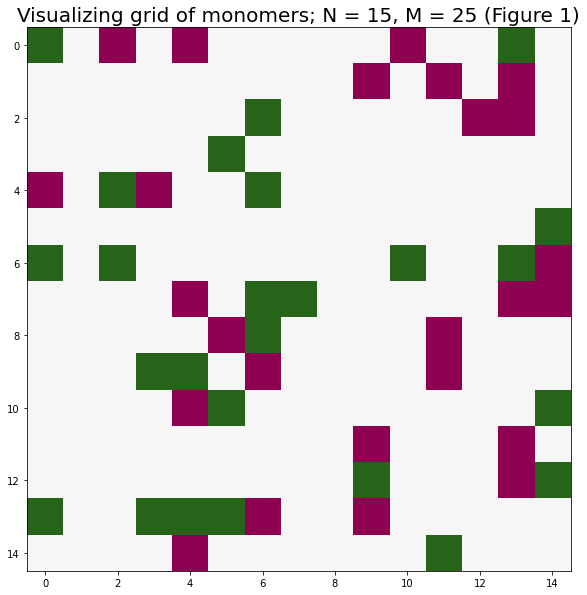

In [3]:
grid = generate_grid_monomers(15,25)
visualize_grid(grid, "Visualizing grid of monomers; N = 15, M = 25 (Figure 1)")

In [4]:
#Calculating total energy of grid in fig 1
energy_of_grid = total_energy(grid)
print(f"The energy of the grid is: {energy_of_grid}")

The energy of the grid is: -3.0


The system of monomers will at all times seek a state of lower energy. Writing a function which is able to calculate the total energy of a grid is therefore crucial.  As mentioned, the only interactions of interest are the ones between neighbors. This is a quite rough, but extremely helpful approximation as it makes the programming and computations easier. In accordance with coloumbs law, we can express the interaction between two nearest neighbors $kl$ as $V_{kl} = w_k w_l \alpha$, where $\alpha = \frac{e^2}{4\pi \epsilon_0 \epsilon_r a}$. **total_energy()** uses this expression to calculate the total energy of a given grid in the dimentionless quantity $\frac{E}{\alpha}$. To find these interactions we inplement the function **get_neighbor_coordinates()**, which returns a list with all four nearest neighbors for a given coordinate. For a monomer situated on the edge of the grid, we use periodic boundary conditions. For finding such coordinates the modulo-operator comes in handy. By choosing the grid presented in $\textbf{figure 1}$ as input in **total_energy()**, we find that the total energy is $-3.0*\alpha = -5.6*10^{-21} Joule$. Since **total_energy()** every interaction twice, the function returns $\frac{E}{2}$.  

#### Function that runs the Monte Carlo simulation

In [5]:
#function that runs the monte carlo simulations and plots the results
def run_monte_carlo_simulation(N_s,N,M,T, filename):
    grid = generate_grid_monomers(N,M)
    grid_final, E_array = monte_carlo_simulation(N_s,N,M,T, grid)

    np.savez(filename, grid_final)

    t = np.linspace(0,N_s-1, N_s)

    np.savez("Energy_"+ filename, [t, E_array])

    d, m, cluster_grid = Find_The_D(grid_final, np.argwhere(grid_final != 0), 0)


    plt.figure(figsize = (15,15))

    #plot both the initial and final grid
    plt.subplot(2,2,1)
    plt.imshow(grid, cmap="PiYG", vmin=-0.5, vmax=0.5)
    plt.title("Initial grid")

    plt.subplot(2,2, 2)
    plt.imshow(grid_final,cmap = "PiYG", vmin = -0.5, vmax = 0.5)
    plt.title("Final grid")

    plt.subplot(2,2,3)
    plt.plot(t,E_array)
    plt.title("Energy as a function of time")
    plt.xlabel("t iterations")
    plt.ylabel("Energy [E/ alpha]")

    plt.subplot(2,2,4)
    plt.imshow(cluster_grid, cmap = "PiYG")
    plt.title("Clusters in the final grid")

    plt.show()

### Monte Carlo simulations for monomers
The Monte Carlo simulations are 

1. T = 200K, N = 15, M = 25, $N_s = 50 \cdot 10^3 $
2. T = 500K, N = 15, M = 25, $N_s = 50 \cdot 10^3 $

As mentioned, we are  using the Marcov Chain Monte Carlo algorithm to simulate the behaviour of a system of monomers for a given temperature $T$. The algorithm picks a random monomer and a random direction, and tries to move it in that particular direction. If it does not collide with another monomer, the move is accepted. The key is now to calculate the total energy of the grid after the move. If $E_{new} < E_{old}$, this is a probable move, and we keep it. If not we discard the move. However, as one can see in **monte_carlo_simulation()**, there is a third possibility. Although $E_{new} > E_{old}$, the move can still pass due to thermal fluctuations. 

Our aim for the first set of simulations was to compare the behaviour of monomers for different temperatures. We ran two simulations with $T=200K$ and $T=500K$, and used $N_s = 50000$ timesteps, and the results can be seen in $\textbf{figure 2}$ and $\textbf{figure 3}$ respectively. The reader will observe that the gathering of clusters is much more prominent for the lower teperature. In addition, the monomers seem to arrange themselves with positive and negative charges next to each other to minimize energy. This observation is coherent with $\textbf{figure 4}$, where the development of energy for the two simulations are plotted together. Firstly, one sees how the energy of the grid is at much higher values for the high temperature simulation. This is obviously not a surprising result. Moreover, the plot shows that you need a much higher quantity of timesteps, $t_{equil}$, to reach equilibrium for the low temperature simulation. Determining the amount of steps needed for each system to reach $t_{equil}$ from $\textbf{figure 4}$ is challenging, and for $T=500K$ it seems to fluctuate around some certain value almost immediately. For this run, it seems reasonable to set $t_{equil}$ between $10000$ and $20000$. For the low temperature simulation, it does not look like the grid reaches equilibrium. To be able to determine $t_{equil}$ we therefore need more timesteps, and this observation will be usefull for our next run of simulations. 

#### Figure 2

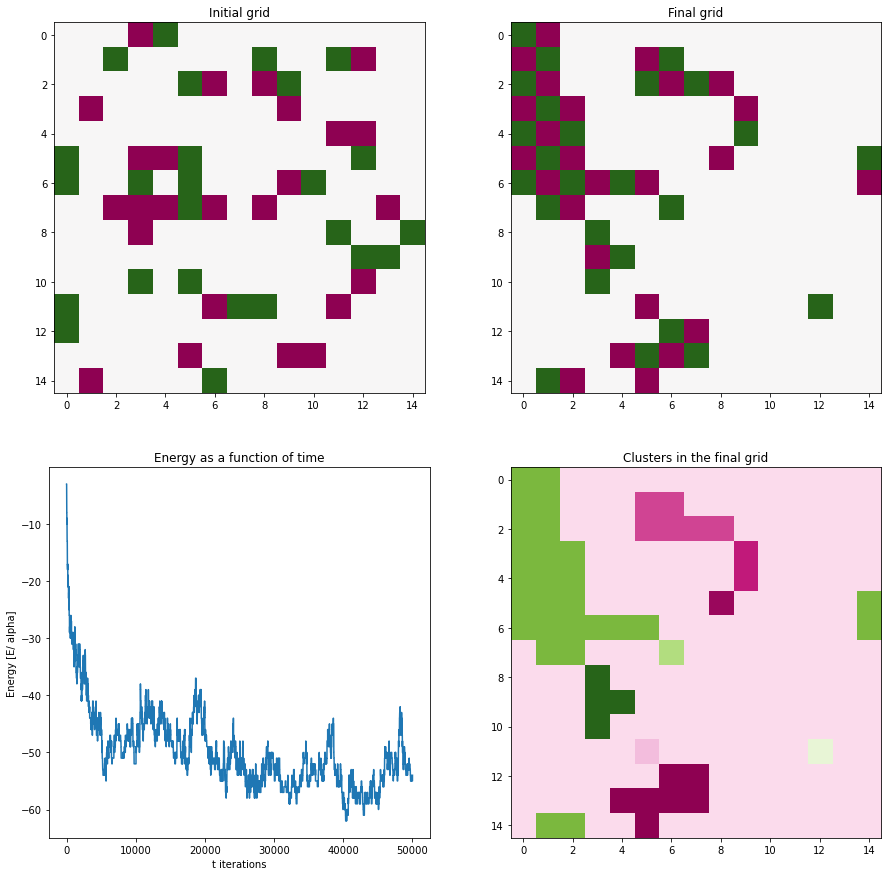

Runtime = 6.669057846069336


In [6]:
N = 15
M = 25
T = 200
N_s = 50000
filename = "T_200_N_15_M_25"

start = time.time()
run_monte_carlo_simulation(N_s,N,M,T, filename)
end = time.time()
print("Runtime = %s" % (end-start))

#### Figure 3

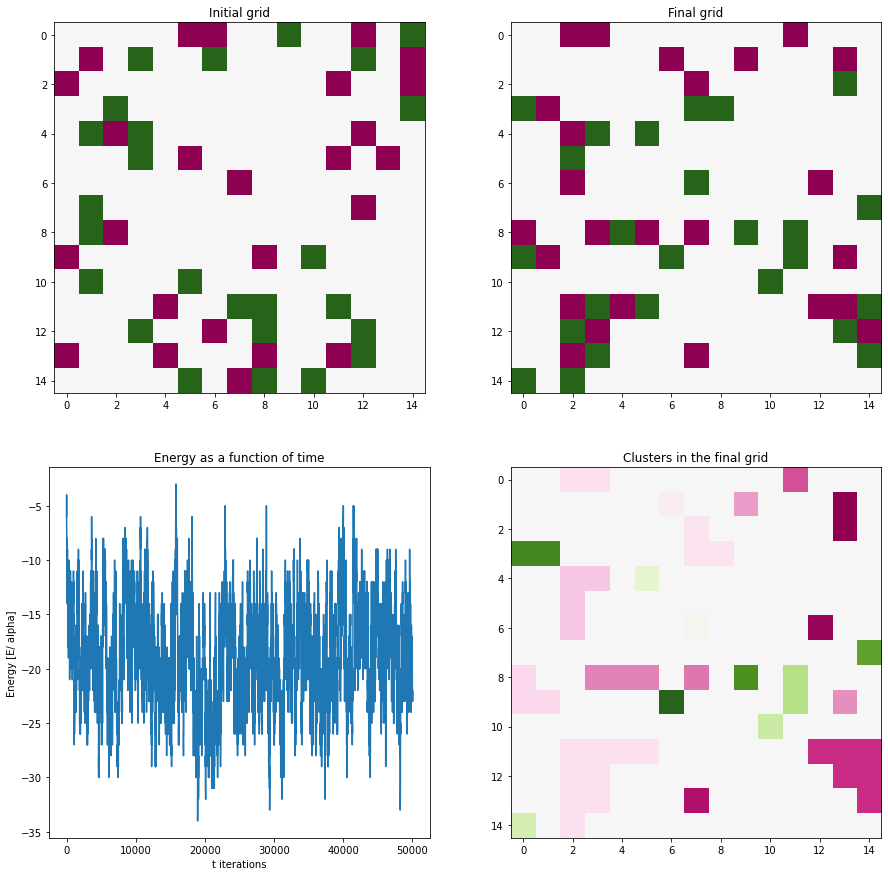

Runtime = 3.9594366550445557


In [7]:
N = 15
M = 25
T = 500
N_s = 50000
filename = "T_500_N_15_M_25"

start = time.time()
run_monte_carlo_simulation(N_s,N,M,T, filename)
end = time.time()
print("Runtime = %s" % (end-start))

#### Energy as a function of time with T = 200K compared with T = 500K
The Monte Carlo simulations are using $N_s = 50\cdot 10^3$ steps.

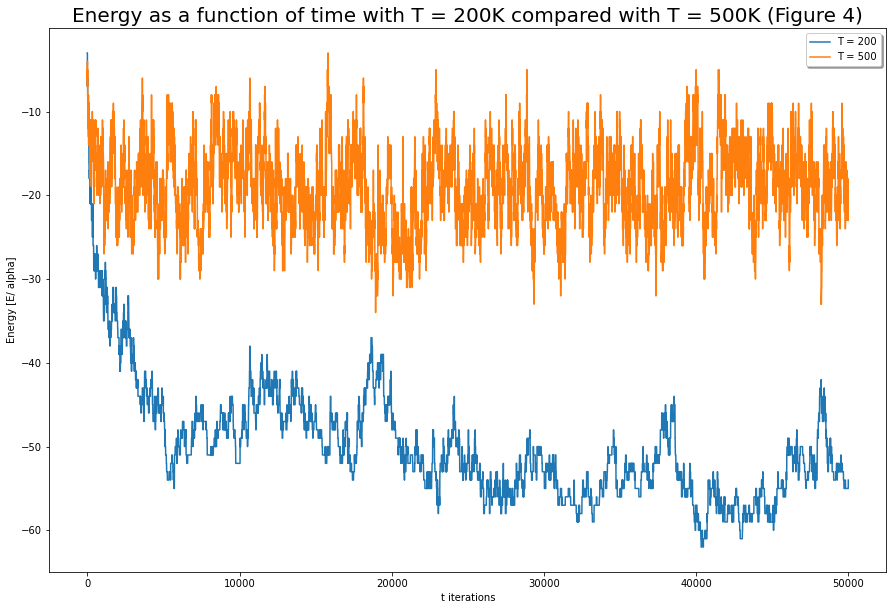

In [8]:
#opens the file that contains the result of the monte carlo simulation
npzfile = np.load("Energy_T_200_N_15_M_25.npz")
npzfile.files
t_200, E_200 = npzfile['arr_0']

npzfile = np.load("Energy_T_500_N_15_M_25.npz")
npzfile.files
t_500, E_500 = npzfile['arr_0']

plt.figure(figsize = (15,10))
plt.plot(t_200, E_200, label = "T = 200")
plt.plot(t_500, E_500, label = "T = 500")
plt.xlabel("t iterations")
plt.ylabel("Energy [E/ alpha]")
plt.title("Energy as a function of time with T = 200K compared with T = 500K (Figure 4)", fontsize=20)
plt.legend(fancybox = True, shadow = True)
plt.show()

In [9]:
#By looking at the graph over you can see that the functions have reached equilibrium around t = 20000
#Uses this to calculate the mean and the standard deviation
E_500_sample = E_500[20000:]

#Calculate the mean and the standard deviation for the energy for T= 500
mean_e_500_sample = np.mean(E_500_sample)
std_e_500_sample = np.std(E_500_sample)

print(f"Mean energy of the T=500 simulation =", round(mean_e_500_sample,1))
print(f"Standard devation of the energy of the T=500 simulation =", round(std_e_500_sample,1))

Mean energy of the T=500 simulation = -19.2
Standard devation of the energy of the T=500 simulation = 4.6


But why is $t_{equil}$ greater for lower temperatures? The system is more likely to stay in a local minima for low temperatures because the probability of the system doing a move that doesn’t minimize the energy is low. In this project the system is doing a move that doesn’t minimize the energy if $\exp(-\beta* \Delta E) > p$ where p is a random number between 0 and 1. $\beta$ is inverse proportional to T. Therefore $\beta$ is small for large T, and this implies that $exp(-\beta* \Delta E)$ is large because $-\beta \Delta E < 0$. Since the the system is more likely to stay in a local minima, it takes longer time for it to find the global minima or a local minima that is deep enough where it's unlikely to escape. If this happens we say it is in equilibrium. This is because it may move in a direction that does not minimize the energy, but it will always come back down to the state with lowest energy. We easily see this on the graph of energy as a function of time, by seeing the energy function oscillating over a given energy. For larger T we can see that the energy function oscillates more, and this is because it does more moves that do not minimize energy. Thus it has the ability to escape more local minimums than for lower temperature.

#### Clustering

The Monte Carlo simulations show how the monomers have a clear tendency to group themselves in clusters, especially for lower temperatures. This is visualized in $\textbf{figure 5}$, where the different clusters for the $T=200K$ simulation are plotted with different colors. This plot is made possible by the function **Find_The_D()**. This function finds mean cluster size, the number of clusters and a cluster grid where monomers in the same cluster have the same value. It achieves this by recursion, in each function call it joins togheter the parts of clusters.

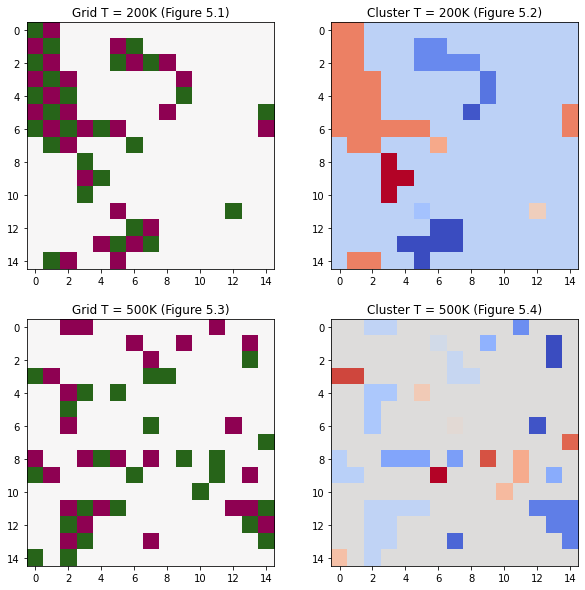

In [10]:
#Getting the cluster for T = 200K
npzfile = np.load("T_200_N_15_M_25.npz")
npzfile.files
grid_200 = npzfile['arr_0']

r_lst = np.argwhere(grid_200 != 0)
temp_grid_200 = grid_200.copy()
d,m,cluster_grid_200 = Find_The_D(temp_grid_200, r_lst, k = 0)

#Getting the cluster for T = 500K
npzfile = np.load("T_500_N_15_M_25.npz")
npzfile.files
grid_500 = npzfile['arr_0']

r_lst = np.argwhere(grid_500 != 0)
temp_grid_500 = grid_500.copy()
d,m,cluster_grid_500 = Find_The_D(temp_grid_500, r_lst, k = 0)


#making a figure where we plot the grid after the MC-simulation side by side the grid where the clusters are highlighted
plt.subplot(2,2,1)
plt.title("Grid T = 200K (Figure 5.1)")
plt.imshow(grid_200, cmap = "PiYG", vmin = -0.5, vmax = 0.5)

plt.subplot(2,2,2)
plt.title("Cluster T = 200K (Figure 5.2)")
plt.imshow(cluster_grid_200, cmap = "coolwarm")


plt.subplot(2,2,3)
plt.title("Grid T = 500K (Figure 5.3)")
plt.imshow(grid_500, cmap = "PiYG", vmin = -0.5, vmax = 0.5)

plt.subplot(2,2,4)
plt.title("Cluster T = 500K (Figure 5.4)")
plt.imshow(cluster_grid_500, cmap = "coolwarm")

plt.show()

### Plotting clustersize against temperature: 

With a function that calculates the mean clustersize for a given grid, we are now ready to examine how the temperature of the system affects the formation of clusters. These simulations are performed by **testMC_clusters()**. This function runs the Monte Carlo simulation until the system reaches equilibrium $t_{equil}$, and starts taking $n$ measurements of $\langle d \rangle$ for every $t_r$ iterations. The observant reader may recall that the number of iterations needed to reach $t_{equil}$ depended on the temperature of the system (see $\textbf{figure 4}$). We therefore include this function in **testMC_clusters()** to determine $t_{equil}$: 

$t_{equil}(T) = t_{max}e^{-s(T-T_{l})} + C$$, with $t_{max} = 100000$, $T_l = 100K$, $s=\frac{1}{200}$ and $C=10000$ \textbf{(1)}$ 

By waiting $t_r$ iterations between each measurement, we obtain $n$ independent measurements. The mean $\langle d \rangle$ for each temperature is then returned as an array. 

Both the mean value returned in **find_The_D()** $(\hat{\mu})$ and the double mean returned in **testMC_clusters()** $(\tilde{\mu})$ are unbiased estimators for $\langle d \rangle$:

$$E[\hat{\mu}] = E[\sum_{i=1}^{k}\frac{1}{k}d_i] = \frac{1}{k}k\mu = \mu$$ $\textbf{(2)}$ 

$$E[\tilde{\mu}]=E[\sum_{j=1}^n\frac1n\sum_{i=1}^{k}\frac{1}{k}d_i] = \frac{1}{nk}nk\mu = \mu$$ $\textbf{(3)}$

$$Var[\hat{\mu}] = Var[\sum_{i=1}^{k}\frac{1}{k}d_i] = \frac{1}{k^2}k\sigma=\frac{\sigma}{k}$$ $\textbf{(4)}$

$$Var[\tilde{\mu}] = Var[\sum_{j=1}^n\frac1n\sum_{i=1}^{k}\frac{1}{k}d_i] = \frac{\sigma}{nk}$$ $\textbf{(5)}$

Here $k$ is the number of clusters and $n$ is the number of measurements per temperature. As one can see from $\textbf{(5)}$, the reliability of the results increases with the number of measurements after $t_{equil}$ has been achieved. 



In [11]:
#Test clusters (task 1h)
@jit(nopython=True)
def testMC_clusters(n, N, M, T_lst, t_max, t_r):
    #Some parameters
    C = 10000
    s = 1/200
    T_l = 100

    d_mean = np.zeros(len(T_lst)) #Array of mean clustersizes
    y_error = np.zeros(len(T_lst))

    for i in range(0, len(T_lst)):
        #calculating the t_equil using the formula over
        t_eq = int(t_max * np.exp(-s * (T_lst[i] - T_l)) + C) #Time before equilibrium
        #Initializing grid
        grid = generate_grid_monomers(N, M)

        #MC simulation until grid reaches equilibrium
        temp_grid, E = monte_carlo_simulation(t_eq, N, 25, T_lst[i], grid)
        
        d_array = np.zeros(n) #Array of clustersizes for one system. 

        d, m, useless_grid = Find_The_D(temp_grid, np.argwhere(grid != 0), 0) #Only interested in the D
        d_array[0] = d

        for j in range(1, n):
            #New simulation every 1000 steps (perhaps not very efficient)
            grid, E = monte_carlo_simulation(t_r, N, 25, T_lst[i], temp_grid)
            d, m,useless_grid = Find_The_D(temp_grid, np.argwhere(grid != 0), 0)
            d_array[j] = d
            temp_grid = grid #prepares for new simulation
        d_mean[i] = np.sum(d_array) / (n) #Calculating mean value for each temperature
        
        #For error-bar:
        y_error[i] = np.std(d_array)

    return d_mean, y_error


T_lst = np.linspace(100, 1000, 10)
start = time.time()
d_mean_1, y_error_1 = testMC_clusters(20, 15, 25, T_lst, 100000, 1000)
d_mean_2, y_error_2 = testMC_clusters(20, 15, 25, T_lst, 100000, 1000)
np.savez("cluster_T_comparison", [d_mean_1, d_mean_2])
end = time.time()
print("Runtime = %s" % (end - start))

Runtime = 82.49657392501831


For our two runs of simulations we have used $t_r = 1000$ and $n=20$. In accordance with $\textbf{figure 2}$ & $\textbf{3}$ the $\langle d \rangle$ has a higher value for low temperatures, and experiences a dramatic decrease between 100 and 300 Kelvin. This can again be explained by the fact that the monomers do fewer non efficient moves, moves which does not minimize energy. Fewer fluctuations facilitates the formation of clusters. Moreover, as $\textbf{figure 6}$ shows, the average clustersize for low temperatures tend to differ quite a lot for every time we run the simulation. This is a reasonable observation, since the formation of clusters for low temperatures is more dependent on the initial grid. This is connected to the idea of a local energy minima introduced earlier. For higher temperatures the initial grid is not as important because the thermal fluctuations have a tendency to "shuffle" the grid. In this way, the grid does not get stuck in a local minimun for higher temperatures. In $\textbf{figure 6}$ we also have included an errorbar which calculates the standard deviation for each temperature. As the plot shows, the standard deviation decreases with higher temeratures, and this helps to underline the explanation above. 

We think that setting $=20$ gives us reliable results, since we then can restrain the variance of the double mean (see equation $\textbf{(5)}$). The code itself is quite quick, and we have run the simulations with higher values of $n$ without it affecting the results that much. To spare time, we therefore landed on $n=20$. 

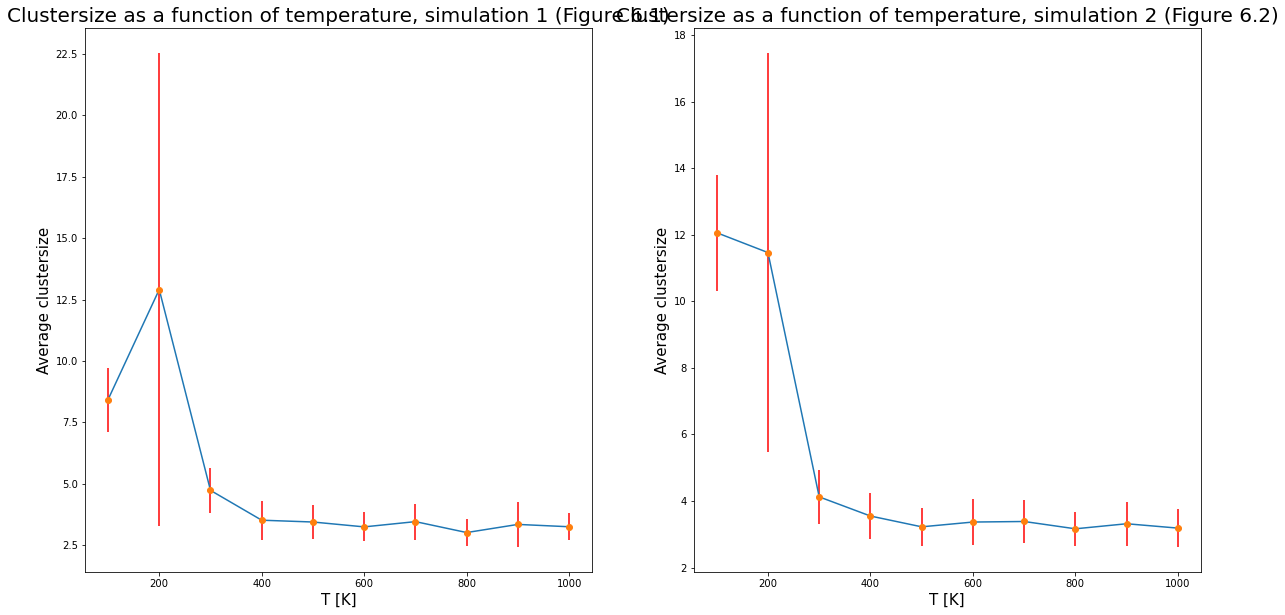

In [12]:
 #Plot
fig = plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(T_lst, d_mean_1)
plt.errorbar(T_lst, d_mean_1, yerr=y_error_1, fmt='o', ecolor='red')
plt.title("Clustersize as a function of temperature, simulation 1 (Figure 6.1)", fontsize=20)
plt.xlabel("T [K]", fontsize=15)
plt.ylabel("Average clustersize", fontsize=15)

plt.subplot(1,2,2)
plt.plot(T_lst, d_mean_2)
plt.errorbar(T_lst, d_mean_2, yerr=y_error_2, fmt='o', ecolor='red')
plt.title("Clustersize as a function of temperature, simulation 2 (Figure 6.2)", fontsize=20)
plt.xlabel("T [K]", fontsize=15)
plt.ylabel("Average clustersize", fontsize=15)

plt.show()

## Polymers

After examinating the formation of clusters of monomers, it will be natural to move our focus onto polymers. From here, we change the value of $a$ to $a=91 \mu m$. As mentioned we now disregard the interactions between monomers belonging to the same polymer, and we have therefore modified **total_energy()**. 

In [13]:
#exercise 2a
#generating M positive and M negative polymers
@jit(nopython = True)
def generate_grid_polymers(N, M, L):
    grid = np.zeros((N,N), dtype=np.dtype('i2'))

    for i in range(-M,M+1):
        if i == 0:
            continue

        #Random monomer
        x = randint(0,N-1)
        y = randint(0,N-1)

        while grid[y][x] != 0:
            x = randint(0,N-1)
            y = randint(0,N-1)

        grid[y,x] = i
        monomers_pos = np.zeros((L,2),dtype=np.dtype('i2'))
        monomers_pos[0] = [x, y]

        #adding L-1 to the polymer
        for j in range(1,L):
            #takes a random monomer in the polymer and checks if it has an available neigbours for the next monomer in the polymer
            while True:
                rand_monomer_num = randint(0, j-1)
                rand_monomer_pos = monomers_pos[rand_monomer_num]
                neighbours = get_neighbour_coordinates(grid,rand_monomer_pos[0], rand_monomer_pos[1])

                available_neighbours = []
                for pos in neighbours:
                    if grid[pos[1],pos[0]] == 0:
                        available_neighbours.append(pos)
                
                if len(available_neighbours) > 0:
                    r = randint(0, len(available_neighbours)-1)
                    monomers_pos[j] = available_neighbours[r]
                    grid[available_neighbours[r][1]][available_neighbours[r][0]] = i
                    break

    return grid

#visualizing a grid with polymers
def visualize_grid_polymers(grid, title = ""):
    plt.rcParams['figure.figsize'] = [10, 10] #Bigger plot
    plt.title(title)
    plt.imshow(grid, cmap="PiYG")
    plt.show()

#Probably a faster np func for this, but not sure
#Help function to broken_polymer
#check if element(2x1 array) is in lst
@jit(nopython = True)
def is_in(lst,element):
   for l in lst:
       if l[0] == element[0] and l[1] == element[1]:
           return True
   return False

#This is a breath first search
#Find out if polymer_val is a contious shape
@jit(nopython = True)
def broken_polymer(grid,polymer_val):
    size = len(np.argwhere(grid == polymer_val))
    lst = np.full(shape=(size,2),fill_value=-1)
    lst[0]= np.argwhere(grid == polymer_val)[0]
    k=0
    l=1
    while(k < len(lst) and k<l):
        nn = get_neighbour_coordinates(grid,lst[k][0], lst[k][1])

        for n in nn:       
            if grid[n[0]][n[1]] == grid[lst[0][0]][lst[0][1]] and not(is_in(lst,n)):
                lst[l] = [n[0],n[1]]
                l=l+1
        k=k+1
        
    if(k ==len(lst)):
        return False
    else:
        return True


#### Visualizing grid polymers

In the same manner as for the monomers, our first goal here is to generate a grid of $2M$ polymers. The function **generate_grid_polymers()** is almost a copy of **generate_grid_monomers**, but here we also take the multivalency $L$ as input. After placing out a monomer at a random spot on the grid, the function uses **get_nearest_neighbors** to build a polymer by adding the remaining $L-1$ monomers. All the monomers bellonging to the same polymer now holds the same value. $\textbf{Figure 7}$ shows a grid consisting of 10 polymers. 

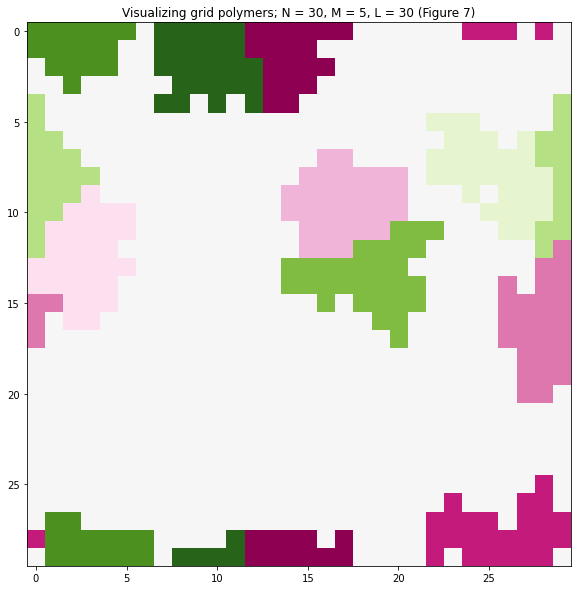

In [14]:
grid = generate_grid_polymers(30, 5, 30)

visualize_grid_polymers(grid, "Visualizing grid polymers; N = 30, M = 5, L = 30 (Figure 7)")

In [15]:
#return True if legal move, False if ilegal
@jit(nopython = True)
def move_polymer_rigid(grid, polymer_value, direction,L):
    #finds all the monomers with polymer_value
    monomer_coordinates = np.argwhere(grid == polymer_value)

    #grid[grid == polymer_value] = 0

    for pos in monomer_coordinates:
        grid[pos[0]][pos[1]] = 0

    #goes through every monomer in the polymer
    for mon in monomer_coordinates:
        #finds the nearest neighbours and the neighbour in the desired direction
        array_of_all_neighbor_coordinates = get_neighbour_coordinates(grid, i=mon[1],j=mon[0])
        desired_neigbor_coordinate = array_of_all_neighbor_coordinates[direction]

        #checks if the neighbour in the desired direction is equal to 0 or is in the same polymer, if not the move isn't possible
        if (grid[desired_neigbor_coordinate[1]][desired_neigbor_coordinate[0]]==0):
            grid[desired_neigbor_coordinate[1]][desired_neigbor_coordinate[0]] = polymer_value
        else:
            return False

    return True

@jit(nopython = True)
def move_polymer_semi_flexible_2(grid, polymer_value, direction, L):
    N = grid.shape[0]
    
    for i in range(N):
        #the moves in x direction
        if direction == 0 or direction == 1:

            x_vals = np.where(grid[i,:] == polymer_value)[0]
            
            y_vals = np.ones(len(x_vals), dtype =np.dtype('i2')) * i


        #the moves in y direction
        elif direction == 2 or direction == 3:

            y_vals = np.where(grid[:,i] == polymer_value)[0]
            x_vals = np.ones(len(y_vals), dtype = np.dtype('i2')) * i


        #positons of the moved monomers in the row
        pos_moved_monomers = []

        for j in range(len(x_vals)):

            x = int(x_vals[j])
            y = int(y_vals[j])
    

            n = get_neighbour_coordinates(grid, x, y)[direction]

            if grid[n[1]][n[0]] == 0 or grid[n[1]][n[0]] == polymer_value:
                #added the position of the moved monomer
                pos_moved_monomers.append((n[0], n[1]))

            else:
                break

        #checks if the number of monomers with legal moves in the row/column is equal to the number of monomers belonging to the polyme in the row/column
        if len(pos_moved_monomers) == len(x_vals):
            for z in range(len(x_vals)):
                #print(grid[int(y_vals[z])][int(x_vals[z])] == polymer_value)
                grid[int(y_vals[z])][int(x_vals[z])] = 0

            for pos in pos_moved_monomers:
                    grid[pos[1]][pos[0]] = polymer_value


    if broken_polymer(grid, polymer_value):    
        return False

    return True

### Running the monte carlo simulation for polymers

After generating a random grid of polymers, the next step will be to see how these interact with each other. We will again perform a simulation using the Metropolis algorithm, where a random polymer and a random direction are chosen. The contrast with earlier simulations now lies in moving the given polymer. The easier choice would be to move the whole polymer without changing its shape. This operation is executed by the function **move_polymer_rigid()** above. The function will try to move the whole polymer rigidly, and returns true if the move is legal. 

Moving polymers around like this is not a very realistic approach, and we therefore introduce **move_polymer_semi_flexible_2()**. Now we have a more flexible way of moving the polymers, where we can change the shape of a polymer, which gives a wider range of legal moves. This function has the ability to keep a row or column in place while the rest of the polymer moves to prevent collisions between polymers. Lastly, it makes shure the molecule is still in one piece thanks to **broken_polymer()**. If not, the move is not accepted.  

Our aim is now to run **monte_carlo_simulation_2()** twice to observe how the flexibility of the polymers affects clustering. **monte_carlo_simulation_2()** therefore takes move as input. 

In [16]:
#initial conditions
e_r = 78
a_p = (91*1.e-6)**2

def monte_carlo_simulation_2(N_s, N, M, L, T, grid, move):
    
    #constants
    beta = 1 / (Boltzmann * T)
    alpha = (elementary_charge)**2 / (4*np.pi*epsilon_0*e_r*a_p)
    k = beta * alpha

    #energy array and calculating the start energy
    E_array = np.zeros(N_s, dtype=np.dtype('i2'))
    #E = total_energy_grid(grid,M)
    E = total_energy(grid)
    E_array[0] = E

    for i in range(0,N_s):
        #copy the grid
        grid_new = grid.copy()
    
        #desiding the random monomer we are moving
        magnitude = randint(1,M)
        sign = 2*randint(0,1) - 1
        direction = randint(0,3)

        #checks if the move is legal
        if not move(grid_new, sign*magnitude, direction, L):
            E_array[i] = E
            grid_new = None
            continue

        #calculating the energy of the new grid
        E_new = total_energy(grid_new)

        #comparing the energy and desciding what the next move is
        if (E_new < E):
            grid = grid_new
            E = E_new

        elif np.exp(-k * (E_new - E)) > random.random():
            grid = grid_new
            E = E_new

        grid_new = None

        E_array[i] = E

    return grid, E_array

In [17]:
def run_monte_carlo_simulation_polymer(N_s,N,M,L,T, move, filename):
    grid = generate_grid_polymers(N,M,L)
    grid_final, E_array = monte_carlo_simulation_2(N_s,N,M,L,T, grid, move)

    t = np.linspace(0,N_s-1, N_s)

    np.savez(filename + "_polymer", grid_final)
    np.savez("Energy_"+ filename + "_polymer", [t, E_array])

    #finding the clusters in the final grid
    temp_grid = grid_final.copy()
    r_list = np.argwhere(grid_final != 0)
    d,m,cluster_grid = Find_The_D(temp_grid, r_list)

    #plot both the initial and final grid
    plt.figure(figsize = (15,15))
    plt.subplot(2,2,1)
    plt.imshow(grid, cmap="PiYG")
    plt.title("Initial grid")

    plt.subplot(2,2, 2)
    plt.imshow(grid_final,cmap = "PiYG")
    plt.title("Final grid")

    plt.subplot(2,2,3)
    plt.plot(t,E_array)
    plt.title("Energy as a function of time")
    plt.xlabel("t iterations")
    plt.ylabel("Energy [E/ alpha]")


    #plotting the clusters
    plt.subplot(2,2,4)
    plt.imshow(cluster_grid,cmap = "coolwarm")
    plt.title("Clusters")

    plt.show()

#### Figur 8

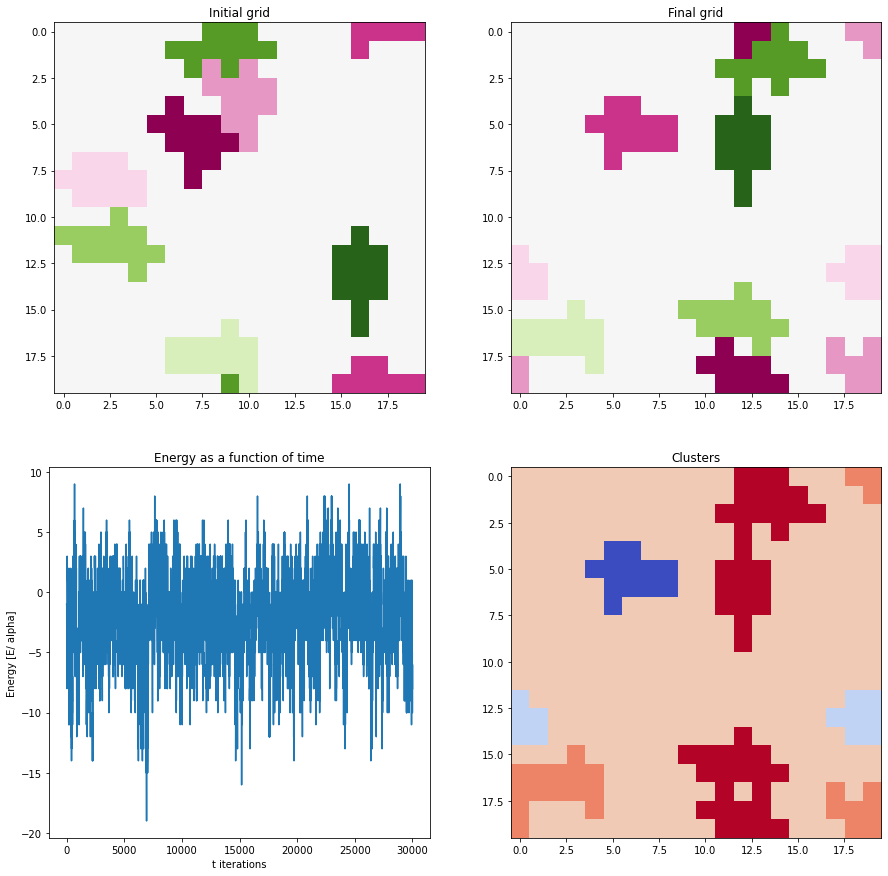

Runtime = 5.3677990436553955


In [18]:
start = time.time()
run_monte_carlo_simulation_polymer(30000, 20, 4,12 ,200, move_polymer_rigid, "rigid_T_200_N_20_M_3_L_20")
end = time.time()
print("Runtime = %s" % (end-start))

For the simulation above we chose $N=20$, $M=4$ and $L=12$. Since we implemented the rigid move,the polymers have kept their shape, as the reader can see in $\textbf{figure 8}$. The lack of flexibility seems to keep the polymers from clustering, something which is also in coherence with the energyplot. The energy of the grid clearly oscillates, and does not seem to find a local minima. This indicates that most of the moves are due to thermal fluctuations. Moves which minimize energy are less common because the shape of the polymers makes it difficult for monomers of opposite charge to be nearest neighbors, hence clustering becomes difficult. 


Simulating polymers have given a considerable longer runtime, and this increase first and foremost lies in moving the polymers versus moving single monomers. For every move we have to move each monomer in the polymer. That is L times more than for the monomers. We also have to check if every monomer move is legal. It can move to a position where there already exists a monomer if the monomer is the same polymer. If one monomer in the polymer can't move, the move is not done. In addition, we always have to make sure that the polymer is not broken for the medium flexible move.

The runtime before reaching equiliberum with the given a, temperatur and other parameters seems to be lower than for the monomers. This is due to that energy unefficient moves have a very high propability for being accepted. This makes it almost impossible for the system to become stuck in minimal energy configuration.  


#### Figur 9

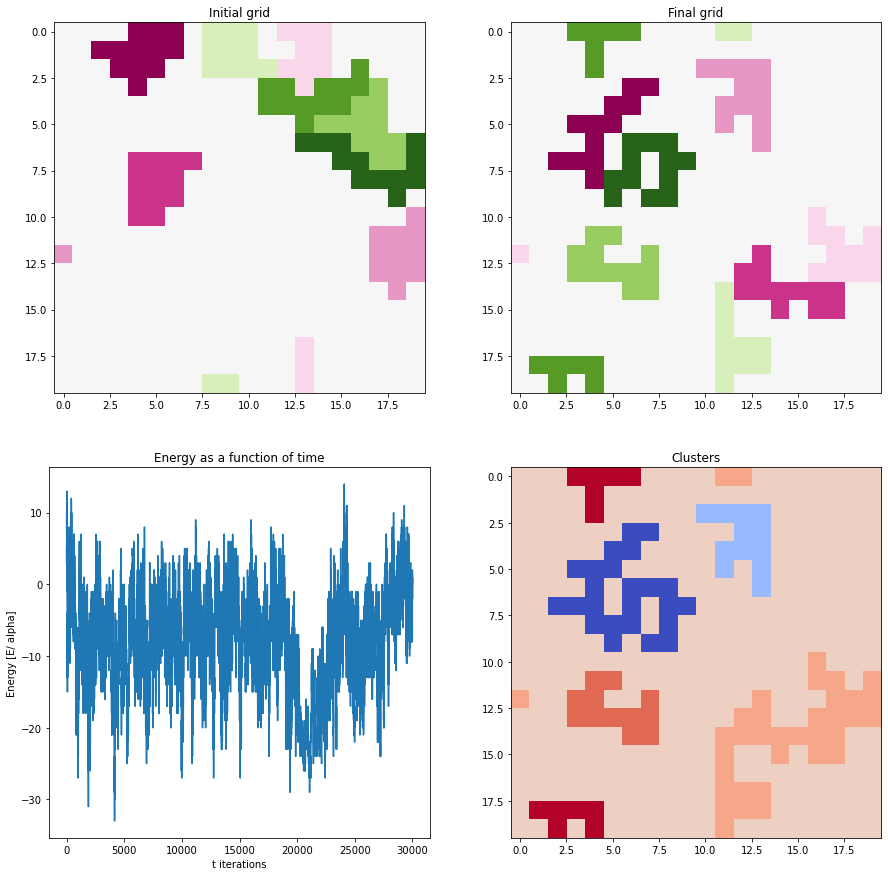

Runtime = 6.904360055923462


In [19]:
start = time.time()
run_monte_carlo_simulation_polymer(30000, 20, 4,12 ,200, move_polymer_semi_flexible_2, "medium_flexibility_T_200_N15_M_2_L_20")
end = time.time()
print("Runtime = %s" % (end-start))

One can easily see that applying the medium flexible move changes the shape of the polymers drastically $\textbf{(figure 9)}$. Since the polymers now have more posssible ways to go, they cluster more than for the rigid move. However, the clustering is not as prominent as we had hoped for. As the energyplot shows, there is still a lot of thermal fluctuation, but generally the energy is lower than for the rigid move. In comparisone to flexibal move the energy variation with medium flexibible move is also greater, this makes sense because there is more flexibility making it possible with greater variation in energy. Setting $a=91\mu m$ has increased the amount of moves which pass due to thermal fluctuations. By lowering $a$, one will see how the medium flexible move induces the gathering of clusters. It then becomes quite clear that the gathering of clusters reduces the total energy of the system. Lowering $a$ in this context will be equivalent with lowering the temperature $T$.   

In [20]:
#@jit(nopython=True)
def simulateClustersPolymers(n, N, M, L_lst, t_eq, t_r, T): 
    #Finding the average cluster size and average number of cluster for different polymer sizes L
    av_d = np.zeros(len(L_lst))
    av_m = np.zeros(len(L_lst))
    sd_d = np.zeros(len(L_lst))
    sd_m = np.zeros(len(L_lst))

    #For each L we first run to equilibrium, from there we take n with t_r steps between
    for j in range(0, len(L_lst)):
        L = int(L_lst[j])


        grid = generate_grid_polymers(N,M,L)
        grid, E_arr = monte_carlo_simulation_2(t_eq, N, M, L, T, grid, move_polymer_semi_flexible_2)


        d_vals = np.zeros(n)
        m_vals = np.zeros(n)

        #first test
        temp_grid = grid.copy()
        r_lst = np.argwhere(grid != 0)
        d_vals[0], m_vals[0], useless_grid = Find_The_D(temp_grid, r_lst, k = 0)

        #running the remainding n-1 test
        for i in range(1,n):
            temp_grid = grid.copy()
            r_lst = np.argwhere(grid != 0)
            d_vals[i], m_vals[i] ,useless_grid = Find_The_D(temp_grid, r_lst, k = 0)
            grid, E_arr = monte_carlo_simulation_2(t_r, N, M, L, T, grid, move_polymer_semi_flexible_2)

        av_d[j] = np.mean(d_vals) / L 
        av_m[j] = np.mean(m_vals)
        sd_d[j] = np.std(d_vals) /L
        sd_m[j] = np.std(m_vals)


    return av_d, av_m, sd_d, sd_m

#### Clustersize and average number of clusters

We are now ready for the last simulation of this project. Using the medium flexible move, our aim is now to compare the average clustersize $\langle d \rangle/L$ and the average number of clusters $\langle m \rangle$ as a function of $L$. This simulation is quite similar to the last we did for monomers, and again we let the system reach equilibrium $t_{equil}$ before taking $n$ measurements. To achieve independent measurements we wait $t_r$ timesteps between each measurement. The simulation is carried out by the function **simulateClustersPolymers()**, and both quantities of interest are found by **Find_the_D()**. 

In [21]:
T = 300
N = 30
M = 5
t_r = 1000

L_vals = np.linspace(3,39, 13)
start = time.time()
av_d, av_m, sd_d, sd_m = simulateClustersPolymers(50, 30, 5, L_vals, 20000, 1000, T)
end = time.time()
print("Runtime = %s" % (end-start))

Runtime = 247.66119599342346


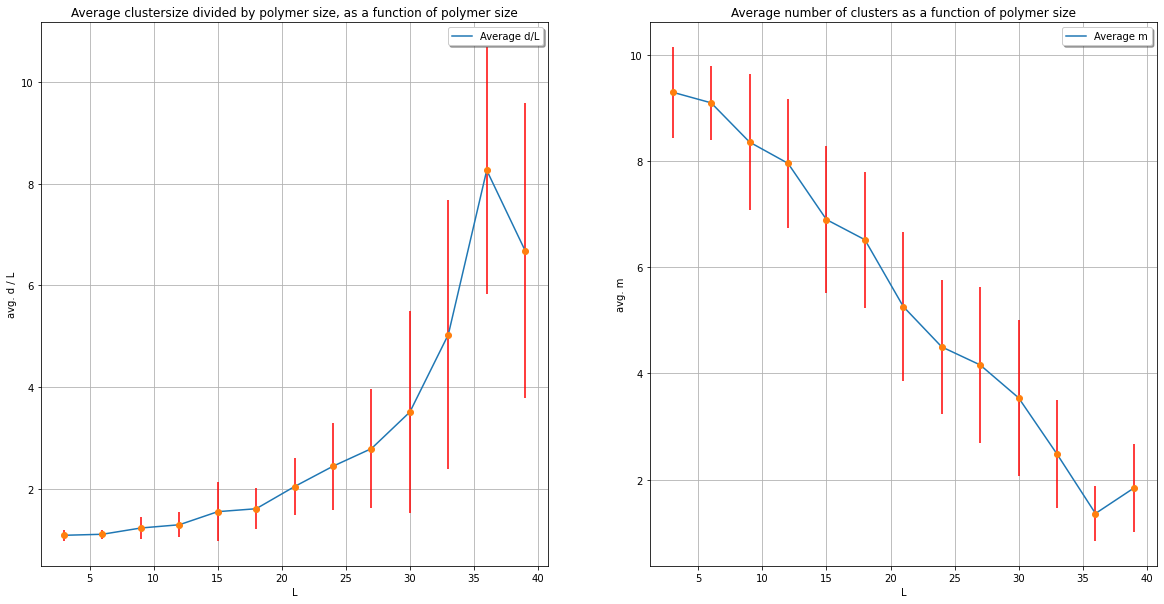

In [22]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.plot(L_vals, av_d, label="Average d/L")
plt.errorbar(L_vals, av_d, yerr=sd_d, fmt='o', ecolor='red')
plt.xlabel("L")
plt.ylabel("avg. d / L")
plt.title("Average clustersize divided by polymer size, as a function of polymer size")
plt.grid(True)
plt.legend(fancybox = True, shadow = True)

plt.subplot(1,2,2)
plt.plot(L_vals, av_m, label="Average m")
plt.errorbar(L_vals, av_m, yerr=sd_m, fmt='o', ecolor='red')
plt.xlabel("L")
plt.ylabel("avg. m")
plt.title("Average number of clusters as a function of polymer size")
plt.grid(True)
plt.legend(fancybox = True, shadow = True)

plt.show()

We run $t_{equil} = 20000$ and $n=50$, and we think that this will yield reliable results while not taking a huge amount of computing power and time. As dicussed earlier the system will reache equiliberium quit fast so 20000 itteration is sufficient before begining to measure.

In $\textbf{figure 10}$ $\langle d \rangle/L$ and $\langle m \rangle$ are plotted side by side as a function of $L$. **simulateClustersPolymers()** has taken measurements for 13 evenly spaced values of $L$ between 3 and 39. The plot clearly shows how increasing multivalency induces the formation of aggregates. 

This is a reasonable results because the polymers have less space for an increasing L. When each polymer have less space the distances between the polymers decreases and they are more likely to be in a cluster. 

But what would happen if we instead applied the rigid move to this simulation? As we saw in $\textbf{figure 8}$, the lack of flexibility seems keep the polymers from forming aggregates. We would probably see a lower value $\langle d \rangle / L$, and of course then also a higher value of $\langle m \rangle$.

From the plots of standard deviation of $\frac{\langle d \rangle}{L}$ we see that the standard devition increases with L. This is not surprising because the value increases with L. Furthermore if there is a change in the number of clusters the average clustersize will be change drastically for a large L. This is because of the low number of cluster for large L. It is important to note that we only have taken measurments from ONE system for each L. Standard devition is therefore calculated over mesurments generated by the same initial grid. We take the measurments 1000 iterations apart for them to be independent measurments, and we have assume it will reach equilibrium before we start to take measurments assuming the mesurments are independent of the initial grid. This may not be a good assumption expecially for larger L beacuse it is harder for the monomers to move when they take up such a big proportion of the grid, the grid might lock in an specific configuration. However we do not have sufficent evidence of the validity of this proposition.

It would also be interesting to see how the value of $N$ affects the formation of aggregates. If we were to run a similar simulation with $N$ as system parameter, it would be important to bear in mind that $N^2 > 2ML$ at all times. If not, the program will crash since we fill the grid before deploying all the monomers. For low values of N we will have almost as many monomers as possible gridspots. This will of course give a very low value of $\langle m \rangle$ and high value of $\langle d \rangle /L$, but addidtionally a grid with lack of mobility. When increasing $N$ the polymers will have more possibilities to move, and we will see a decrease in clustersize while the number of clusters increase. For some initial system where N is large in comparison with $L$, it is plausible that there will be no formation of clusters. A situation like this can actually be seen in $\textbf{figure 10}$, where $\langle d \rangle /L =1$ and $\langle m \rangle = 2M$ for $L=3$. Studing a grid like this will not give satisfactory results as long as we restrain ourselves to interactions between nearest neighbors. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=04f249fb-c7d7-444e-a57e-95583905511e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>